In [1]:
from typing import List

import torch
import torch.cuda
from torch.utils.data import DataLoader
from typing import Union
from datetime import datetime

from PIL import Image as PILImage

import numpy as np
import pyml
from models import DiscriminatorPixelMse, DownSampler, GeneratorESPCN, DiscriminatorVggMse, DiscriminatorBaselineNetwork

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = pyml.ImagesDataset.from_dirs_recursive(roots=["datasets/flowers102processed"], channels_order='chw')
batch_size = 8

if torch.cuda.is_available():
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
else:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
class GanHelper:
    def __init__(self, data_loader: DataLoader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data_loader = data_loader
        scale = 4
        self.generator = GeneratorESPCN(channels=128, upscale=scale).to(self.device)

        self.d_pixel_mse = DiscriminatorPixelMse(weight=1.0)
        self.d_vgg_mse = DiscriminatorVggMse(weight=0.0001, inpad_size=16).to(self.device)
        self.d_vgg_mse_x2 = DiscriminatorVggMse(weight=0.0001, prescale=2, inpad_size=16).to(self.device)
        self.d_baseline = DiscriminatorBaselineNetwork(generator_weight=0.0001, mid_channels=32, inpad_size=16, dropout=0.5).to(self.device)

        self.downsampler = DownSampler(scale=scale).to(self.device)

        self.losses = []
        self.losses_print_step = 50

    def add_loss(self, losses: List[torch.Tensor]):
        self.losses.append([loss.item() for loss in losses])
        if self.losses_print_step is not None and len(self.losses) % self.losses_print_step == 0:
            av_loss = np.average(np.array(self.losses[-self.losses_print_step:]), axis=0)
            print(f"{len(self.losses)}: {av_loss}")

    def train(self, *, steps: int, lr_g: float = 0.0, lr_d: float = 0.0):
        generator_optimizer = torch.optim.Adam([
            {'params': self.generator.layers.parameters()},
            {'params': self.generator.pixel_shuffle.parameters(), 'lr': lr_g * 0.1}
        ], lr=lr_g)
        discriminator_optimizer = torch.optim.Adam(self.d_baseline.parameters(), lr=lr_d)

        self.generator.train()
        self.d_baseline.train()

        step = 0
        while True:
            for label in self.data_loader:
                label = label.to(self.device)
                label.requires_grad = False
                x = self.downsampler(label)

                # train generator
                if lr_g != 0.0:
                    generator_optimizer.zero_grad()
                    y = self.generator(x)
                    g_losses = [f.loss(y, label) for f in [self.d_pixel_mse, self.d_vgg_mse, self.d_vgg_mse_x2, self.d_baseline]]
                    loss = sum(g_losses)
                    loss.backward()
                    generator_optimizer.step()
                else:
                    g_losses = [torch.zeros(size=[1], device=self.device)]

                # train discriminator
                if lr_d != 0.0:
                    discriminator_optimizer.zero_grad()
                    y = self.generator(x)
                    d_loss = self.d_baseline.loss_for_discriminator(y, label)
                    d_loss.backward()
                    discriminator_optimizer.step()
                else:
                    d_loss = torch.zeros(size=[1], device=self.device)

                self.add_loss(g_losses + [d_loss])

                step += 1
                if step >= steps:
                    return

    def demonstrate(self, label: Union[np.ndarray, torch.Tensor]) -> PILImage:
        if isinstance(label, np.ndarray):
            if len(label.shape) == 3:
                label = label[np.newaxis]
            label = torch.from_numpy(label)
        assert isinstance(label, torch.Tensor)
        label = label.to(self.device)

        self.generator.eval()
        x = self.downsampler(label)
        y = self.generator(x)
        x4x = self.downsampler.upsample(x)

        triple = torch.cat([x4x, y, label], dim=3)
        pic = triple.cpu().detach().numpy()[0]
        pic = np.moveaxis(pic, 0, 2)
        pic = np.clip(pic, 0.0, 1.0)
        img = PILImage.fromarray((pic * 255.0).astype(np.uint8))
        return img

    def save_model(self) -> str:
        suffix = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
        torch.save(self.generator.state_dict(), f"models/espcn/generator_espcn_{suffix}.pth")
        torch.save(self.d_baseline.state_dict(), f"models/espcn/discriminator_baseline_{suffix}.pth")
        return suffix

    def load_model(self, suffix: str):
        self.generator.load_state_dict(torch.load(f"models/espcn/generator_espcn_{suffix}.pth"))
        self.d_baseline.load_state_dict(torch.load(f"models/espcn/discriminator_baseline_{suffix}.pth"))

In [5]:
gan_helper = GanHelper(data_loader)

/home/lgor/projects/2023/pyenv310/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [6]:
gan_helper.train(steps=1 * len(dataset) // batch_size, lr_g=0.0001, lr_d=0.0001)

50: [1.41309135e-01 1.99414998e-02 2.38906290e-02 1.02875382e-04
 6.08753428e-01]
100: [3.30759290e-02 1.64785064e-02 2.19236801e-02 1.26662100e-04
 5.26764385e-01]


In [7]:
gan_helper.train(steps=5 * len(dataset) // batch_size, lr_g=0.001, lr_d=0.001)

150: [2.69100161e-02 1.85948940e-02 2.26994955e-02 1.50505171e-04
 4.87336047e-01]
200: [1.33095423e-02 1.62398433e-02 1.71102254e-02 1.29196666e-04
 5.17718821e-01]
250: [9.40665748e-03 1.44531364e-02 1.31843161e-02 1.53001470e-04
 4.69685742e-01]
300: [7.89051807e-03 1.32897524e-02 1.22577086e-02 1.85605523e-04
 4.01374948e-01]
350: [6.94938217e-03 1.20668904e-02 9.70104630e-03 2.03020889e-04
 3.60817302e-01]
400: [5.45054280e-03 1.04759217e-02 7.40733833e-03 2.33190439e-04
 2.89040116e-01]
450: [5.00046641e-03 9.57024603e-03 6.48482083e-03 2.35283105e-04
 2.96985505e-01]
500: [0.0043513  0.00851395 0.00552407 0.00027824 0.19974009]
550: [0.0042307  0.00847945 0.00534875 0.00035675 0.14421435]
600: [0.004062   0.00862373 0.0055237  0.00037797 0.13231387]
650: [0.0038037  0.00786615 0.00488016 0.00044043 0.07904614]
700: [0.00396491 0.00818267 0.0050444  0.00059875 0.03280973]
750: [0.00343022 0.00739548 0.00463833 0.00053643 0.05112959]


In [8]:
gan_helper.train(steps=30 * len(dataset) // batch_size, lr_g=0.0003, lr_d=0.0003)

800: [0.00395513 0.00772963 0.00476017 0.0006308  0.02783718]
850: [0.00315964 0.00698587 0.00441231 0.00073962 0.00660011]
900: [0.00348454 0.00734119 0.00466978 0.00076847 0.00713337]
950: [0.00341499 0.0073667  0.00465713 0.0007253  0.02099875]
1000: [0.003171   0.00694678 0.00438152 0.00071828 0.01147617]
1050: [0.00325938 0.00699593 0.00439854 0.00078815 0.00838604]
1100: [0.00312028 0.00679008 0.00430748 0.00084119 0.00471846]
1150: [0.00325062 0.00706573 0.0043787  0.00082121 0.01623655]
1200: [0.00321815 0.00744911 0.00445379 0.00076572 0.00960108]
1250: [0.0031813  0.00673093 0.00424959 0.00088814 0.00413216]
1300: [0.00304184 0.00674339 0.00420029 0.00091751 0.00237674]
1350: [0.0031169  0.00685829 0.00426274 0.00095563 0.00182627]
1400: [0.00303229 0.00695528 0.00426273 0.00094581 0.00246639]
1450: [0.00304509 0.0071028  0.00434368 0.00092005 0.00587877]
1500: [0.00312547 0.00670732 0.004182   0.00077533 0.02132172]
1550: [0.002984   0.00655787 0.00402268 0.00084289 0.005337

In [12]:
gan_helper.train(steps=50 * len(dataset) // batch_size, lr_g=0.0001, lr_d=0.0001)

4600: [0.0027606  0.00609637 0.00329014 0.0012369  0.00347046]
4650: [0.00269123 0.00594875 0.00320945 0.00131091 0.00090483]
4700: [0.00289734 0.00623476 0.00336178 0.00142427 0.00048362]
4750: [0.00287434 0.00602293 0.00323359 0.00113822 0.00971136]
4800: [0.00262263 0.00597438 0.00318186 0.00136255 0.00074134]
4850: [0.00273148 0.00602467 0.00326787 0.00131818 0.00186768]
4900: [0.00267865 0.0059289  0.00319343 0.00130377 0.00138472]
4950: [0.00289271 0.00607898 0.00328328 0.00138992 0.00100688]
5000: [0.00274052 0.00606567 0.0032567  0.0014116  0.00113929]
5050: [0.00268088 0.00600386 0.00324498 0.00131081 0.0032482 ]
5100: [0.00288245 0.00615256 0.00329593 0.00130016 0.00660675]
5150: [0.00266722 0.00594883 0.00319013 0.00124316 0.00199763]
5200: [0.00275989 0.00603504 0.00324404 0.00131951 0.00065001]
5250: [0.00273158 0.00590975 0.00317188 0.00138514 0.0021728 ]
5300: [0.0026204  0.00587703 0.00317319 0.00155555 0.00029864]
5350: [0.00275873 0.00603043 0.00322172 0.00145654 0.00

In [23]:
gan_helper.d_baseline.generator_weight = 0.001
gan_helper.train(steps=50 * len(dataset) // batch_size, lr_g=0.0001, lr_d=0.00003)

11000: [0.00332087 0.00655992 0.00372909 0.00203738 0.90477231]
11050: [0.00369734 0.00720431 0.00401549 0.00207073 0.89124981]
11100: [0.00363126 0.00698997 0.00385009 0.00237054 0.63318422]
11150: [0.00347101 0.00690402 0.00377855 0.00205897 0.57998535]
11200: [0.00362094 0.00707662 0.00387319 0.00260116 0.45225683]
11250: [0.00340389 0.00687147 0.00377052 0.00238563 0.52881577]
11300: [0.00340629 0.00681702 0.00374403 0.00261589 0.44467928]
11350: [0.00363343 0.00707568 0.00387388 0.00275965 0.4140365 ]
11400: [0.00355129 0.00689254 0.00377127 0.00260094 0.44653901]
11450: [0.0035078  0.00690129 0.00375254 0.0026986  0.44422182]
11500: [0.00341982 0.00702008 0.00382514 0.00260867 0.44924425]
11550: [0.00344062 0.0070063  0.00378544 0.00261421 0.40242545]
11600: [0.00354901 0.00710546 0.00388099 0.00241515 0.50390559]
11650: [0.00339091 0.00693394 0.00374262 0.00280538 0.38766414]
11700: [0.00336392 0.0070121  0.00381132 0.00266077 0.39312609]
11750: [0.0033441  0.00695579 0.00384386

In [30]:
gan_helper.d_baseline.generator_weight = 0.001
gan_helper.train(steps=100 * len(dataset) // batch_size, lr_g=0.0001, lr_d=0.00003)

17350: [0.00347951 0.0069335  0.00366296 0.00615264 0.06879621]
17400: [0.00344937 0.00698627 0.00370944 0.00548392 0.10398223]
17450: [0.00315188 0.00666484 0.00347142 0.00529144 0.10216203]
17500: [0.00332121 0.00685428 0.00356399 0.00577846 0.07914794]
17550: [0.00350652 0.00706383 0.00373282 0.00579697 0.09542002]
17600: [0.00333527 0.00687594 0.00360136 0.00583975 0.08669735]
17650: [0.00355329 0.007003   0.00368372 0.00562744 0.09417346]
17700: [0.00333913 0.00697624 0.00365959 0.00622091 0.07585729]
17750: [0.00327611 0.00687929 0.00357315 0.00528806 0.10460613]
17800: [0.00320973 0.00676767 0.00355716 0.00559813 0.08380869]
17850: [0.0034754  0.00691958 0.00366085 0.00610923 0.08000864]
17900: [0.00339917 0.00704249 0.00371182 0.00595478 0.080669  ]
17950: [0.00338766 0.00679391 0.00358813 0.00568034 0.08557099]
18000: [0.00346238 0.00704283 0.00370245 0.00600341 0.09985188]
18050: [0.00331092 0.00678386 0.00353934 0.00599053 0.08588029]
18100: [0.00323119 0.00679895 0.00355603

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


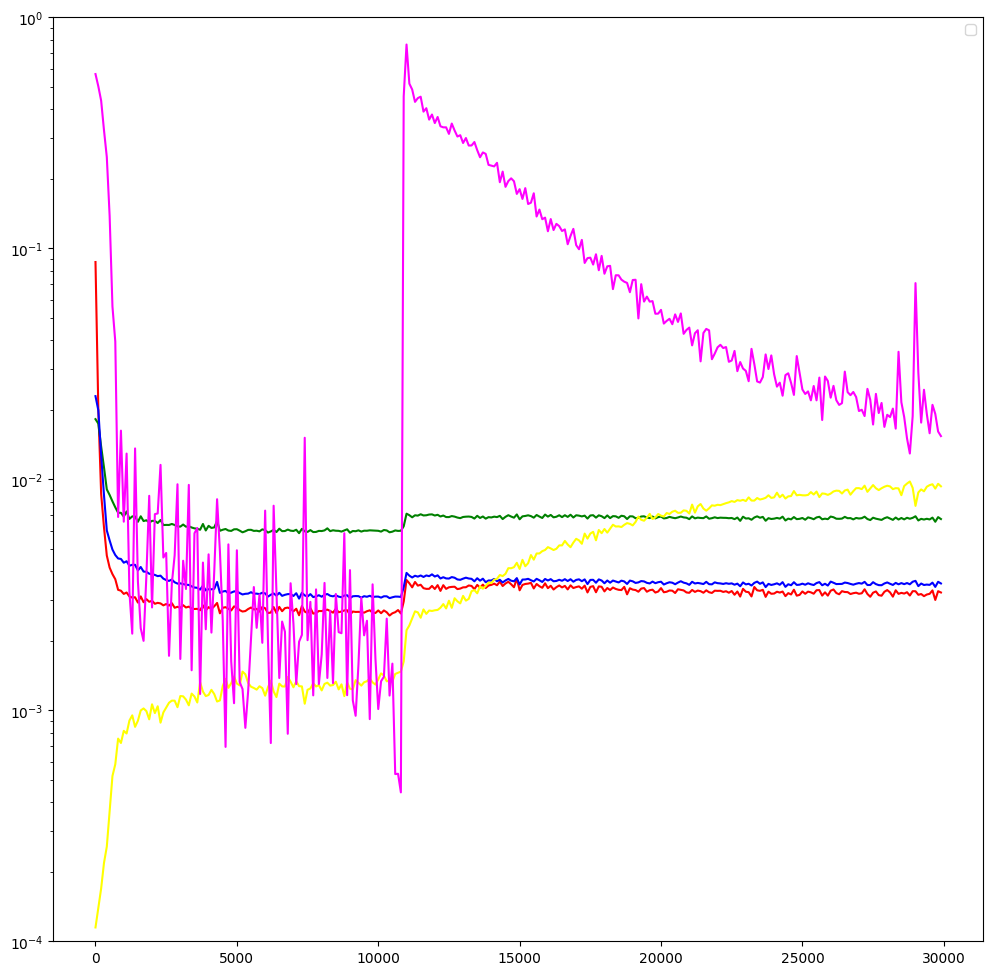

In [31]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylim(0.0001, 1)

def my_plot(lst: List[float], av: int):
    for i, color in enumerate(["red", "green", "blue", "yellow", "magenta"]):
        arr = np.array(lst)[:, i]
        arr = arr[:arr.shape[0] // av * av]
        arr = arr.reshape(-1, av).mean(axis=1)
        ax.plot([i * av for i in range(arr.shape[0])], arr, c=color)

my_plot(gan_helper.losses, av=100)

ax.legend()
plt.show()

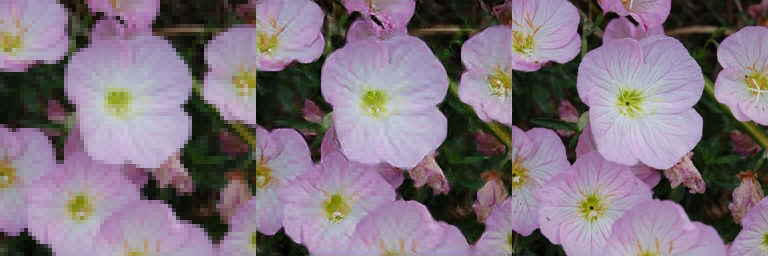

In [32]:
gan_helper.demonstrate(dataset[0])

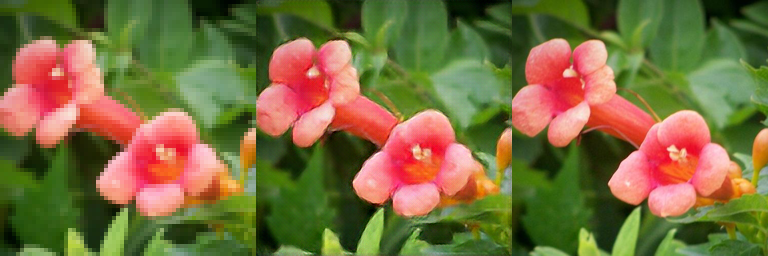

In [33]:
gan_helper.demonstrate(dataset[6])

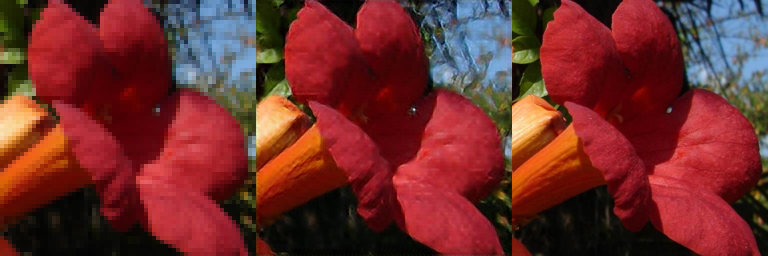

In [34]:
gan_helper.demonstrate(dataset[7])

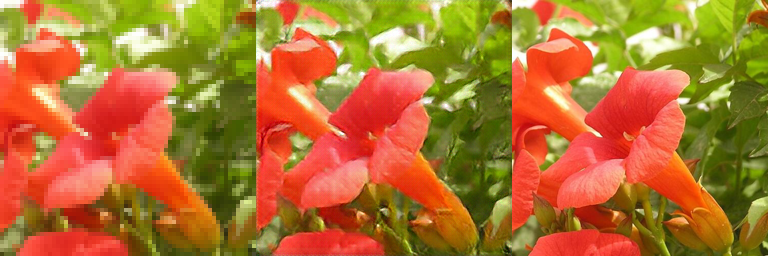

In [35]:
gan_helper.demonstrate(dataset[8])

In [38]:
gan_helper.save_model()

'2023-04-23-01-32-18'